# Compare Flux Redshift data in delight simulation and input DESC using histograms

- Probaby I need to normalize the flux to the Delight simulation

- author : Sylvie Dagoret-Campagne

- affiliation : IJCLab/IN2P3/CNRS
- creation date : March 17th 2021
- update : April 3rd 2021
- last update : May 18 th 2021

data are in 

        ln -s ../tmp
        ln -s ../tmpsim

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import sys
from mpi4py import MPI
import numpy as np
from scipy.interpolate import interp1d
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP
from delight.photoz_kernels import Photoz_mean_function, Photoz_kernel
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import emcee
import corner

# Create a logger object.
logger = logging.getLogger(__name__)
coloredlogs.install(level='DEBUG', logger=logger,fmt='%(asctime)s,%(msecs)03d %(programname)s %(name)s[%(process)d] %(levelname)s %(message)s')

comm = MPI.COMM_WORLD
threadNum = comm.Get_rank()
numThreads = comm.Get_size()

In [3]:
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [4]:
from pkg_resources import resource_filename

# Configuration

## The SED and the Flux Redshift model

In [5]:
#basedelight_datapath = resource_filename('delight', '../data')
basedelight_datapath = os.path.join('tmpsim', 'delight_indata')

In [6]:
topseddir=os.path.join(basedelight_datapath,"CWW_SEDs")

In [7]:
files_sed_cww=["El_B2004a_fluxredshiftmod.txt","SB2_B2004a_fluxredshiftmod.txt","Sbc_B2004a_fluxredshiftmod.txt",
               "ssp_25Myr_z008_fluxredshiftmod.txt","Im_B2004a_fluxredshiftmod.txt","SB3_B2004a_fluxredshiftmod.txt",
               "Scd_B2004a_fluxredshiftmod.txt","ssp_5Myr_z008_fluxredshiftmod.txt"]

In [8]:
NSED=len(files_sed_cww)
NSED

8

In [9]:

flux_multiplicative_factor=0.45e-10 # factor such if it multiplies data flux in sim gives true data flux
flux_multiplicative_factor2=0.45e-4 # factor such if it is multiplied to models it gives true data flux level

## The simulation data

In [10]:
configsimfilename="tmpsim/parametersTest.cfg"

In [11]:
paramssim = parseParamFile(configsimfilename, verbose=True)

2021-06-17 21:12:21,408 ipykernel_launcher.py, delight.io[13829] WARNING Input parameter file:tmpsim/parametersTest.cfg
2021-06-17 21:12:21,412 ipykernel_launcher.py, delight.io[13829] WARNING Parameters read:


>  rootDir              ./
>  bands_directory      ./tmpsim/delight_indata/FILTERS
>  bandNames            lsst_u lsst_g lsst_r lsst_i lsst_z lsst_y
>  numCoefs             15
>  bands_verbose        True
>  bands_debug          True
>  bands_makeplots      False
>  templates_directory  ./tmpsim/delight_indata/CWW_SEDs
>  lambdaRef            4500.0
>  templates_names      El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
>  p_t                  [0.27   0.26   0.25   0.069  0.021  0.11   0.0061 0.0079]
>  p_z_t                [0.23 0.39 0.33 0.31 1.1  0.34 1.2  0.14]
>  templates_verbose    False
>  templates_debug      False
>  training_numChunks   1
>  training_paramFile   ./tmpsim/delight_data/galaxies-gpparams.txt
>  training_catFile     ./tmpsim/delight_data/galaxies-fluxredshifts.txt
>  training_referenceBand lsst_i
>  training_bandOrder   lsst_u lsst_u_var lsst_g lsst_g_var lsst_r lsst_r_var lsst_i lsst_i_var lsst_z lsst_z_var lsst_y ls

## The DC2 data

In [12]:
configdatafilename="tmp/parametersTest.cfg"

In [13]:
paramsdata = parseParamFile(configdatafilename, verbose=True)

2021-06-17 21:12:21,533 ipykernel_launcher.py, delight.io[13829] WARNING Input parameter file:tmp/parametersTest.cfg
2021-06-17 21:12:21,535 ipykernel_launcher.py, delight.io[13829] WARNING Parameters read:


>  rootDir              ./
>  bands_directory      ./tmp/delight_indata/FILTERS
>  bandNames            lsst_u lsst_g lsst_r lsst_i lsst_z lsst_y
>  numCoefs             15
>  bands_verbose        True
>  bands_debug          True
>  bands_makeplots      False
>  templates_directory  ./tmp/delight_indata/CWW_SEDs
>  lambdaRef            4500.0
>  templates_names      El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
>  p_t                  [0.27   0.26   0.25   0.069  0.021  0.11   0.0061 0.0079]
>  p_z_t                [0.23 0.39 0.33 0.31 1.1  0.34 1.2  0.14]
>  templates_verbose    False
>  templates_debug      False
>  training_numChunks   1
>  training_paramFile   ./tmp/delight_data/galaxies-gpparams.txt
>  training_catFile     ./tmp/delight_data/galaxies-fluxredshifts.txt
>  training_referenceBand lsst_i
>  training_bandOrder   lsst_u lsst_u_var lsst_g lsst_g_var lsst_r lsst_r_var lsst_i lsst_i_var lsst_z lsst_z_var lsst_y lsst_y_var red

# Decode parameters

In [14]:
DL = approx_DL()
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(paramssim)

In [15]:
numZ = redshiftGrid.size

# Read data flux Redshift for  the simulation

In [16]:
# Locate which columns of the catalog correspond to which bands.
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,refBandColumn = readColumnPositions(paramssim, prefix="training_")

# Read the model

- The Flux-Redshift model for each template is stored in the SED directory

In [17]:
dir_seds = paramssim['templates_directory']
dir_filters = paramssim['bands_directory']

In [18]:
lambdaRef = paramssim['lambdaRef']
sed_names = paramssim['templates_names']
numBands = bandIndices.size
nt = len(sed_names)

In [19]:
f_mod = np.zeros((numZ, nt, len(paramssim['bandNames'])))

In [20]:
# model of flux-redshift for each template
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')

## Read the simulation training Flux-Redshift dataset

- in Simulation mode, this file has been produced by **simulateWithSEDs(delightparamfile)** , ie **./tmpsim/delight_data/galaxies-fluxredshifts.txt**

In [21]:
numObjectsTraining = np.sum(1 for line in open(paramssim['training_catFile']))

<ipython-input-21-48b75aa74918>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(paramssim['training_catFile']))


In [22]:
numMetrics = 7 + len(paramssim['confidenceLevels'])

In [23]:
allFluxessim = np.zeros((numObjectsTraining, numBands))
allFluxesVarsim = np.zeros((numObjectsTraining, numBands))

redshiftssim = np.zeros((numObjectsTraining, 1))
fmod_atZsim = np.zeros((numObjectsTraining, nt, numBands))

ellsim= np.zeros(numObjectsTraining)

In [24]:
# Now loop over training set to compute likelihood function
loc = - 1
trainingDataIter = getDataFromFile(paramssim, 0, numObjectsTraining,prefix="training_", getXY=False)

In [25]:
# loop on training
for z, ell, bands, fluxes, fluxesVar, bCV, fCV, fvCV in trainingDataIter:
   
    loc += 1
    
    ellsim[loc] =ell

    allFluxessim[loc, :] = fluxes
    allFluxesVarsim[loc, :] = fluxesVar
    redshiftssim[loc, 0] = z
    
    # loop on SED
    for t, sed_name in enumerate(sed_names):
        for ib, b in enumerate(bands):
            fmod_atZsim[loc, t, ib] = ell * np.interp(z, redshiftGrid,f_mod[:, t, b])

# Luminosity Factor

Text(0.5, 1.0, 'Normalisation factor $\\ell$ for luminosity in sim')

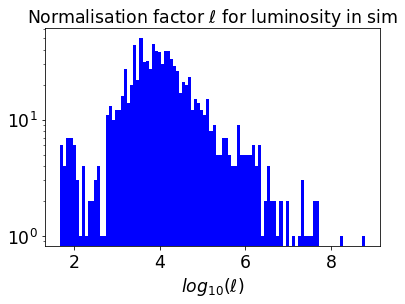

In [26]:
plt.hist(np.log10(ellsim),bins=100,facecolor="b");
plt.yscale("log")
plt.xlabel("$log_{10}(\ell$)")
plt.title("Normalisation factor $\ell$ for luminosity in sim")

In [27]:
ellsim_mean=ellsim.mean()

In [28]:
ellsim_mean

1318202.4762914777

# Compare SED model with Flux-Redshift data in simulation

Text(0.5, 1.01, 'Delight Simulation : Flux-Redshift model comparison between model and simulated data')

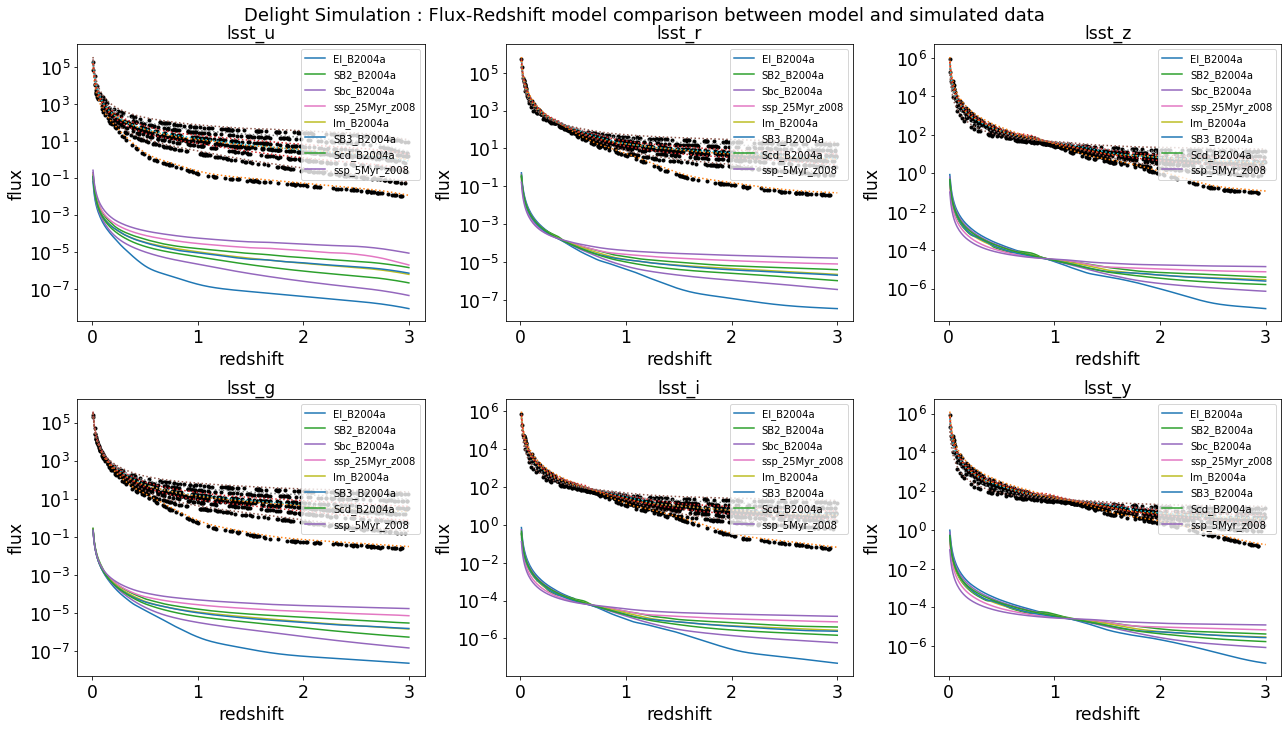

In [29]:
ncol=3
nrow=2
fig, axes = plt.subplots(nrow, ncol,figsize=(18,10)) 

for ised in np.arange(NSED):
    filename=files_sed_cww[ised]
    sedname=filename.split("_fluxredshiftmod")[0]
    fullfilename=os.path.join(topseddir,filename)
    flux=np.loadtxt(fullfilename)
    for ifilt in np.arange(6):
        ix=ifilt//2
        iy=ifilt-ix*2
        
        axes[iy,ix].plot(redshiftGrid,flux[:,ifilt],label=sedname)
        axes[iy,ix].plot(redshiftGrid,ellsim_mean*flux[:,ifilt],":")
        axes[iy,ix].legend(loc="upper right")
        if ised==0:
            axes[iy,ix].set_yscale("log")
            axes[iy,ix].set_title(bandNames[ifilt])
            axes[iy,ix].set_xlabel("redshift")
            axes[iy,ix].set_ylabel("flux")
            axes[iy,ix].scatter(redshiftssim[:, 0],allFluxessim[:, ifilt],marker=".",color="k" )
            
plt.tight_layout() 
plt.suptitle("Delight Simulation : Flux-Redshift model comparison between model and simulated data",fontsize=18,y=1.01)


## Check normalisation

Text(0.5, 1.01, 'Delight Simulation : Flux-Redshift model comparison between rescaled model and simulated data')

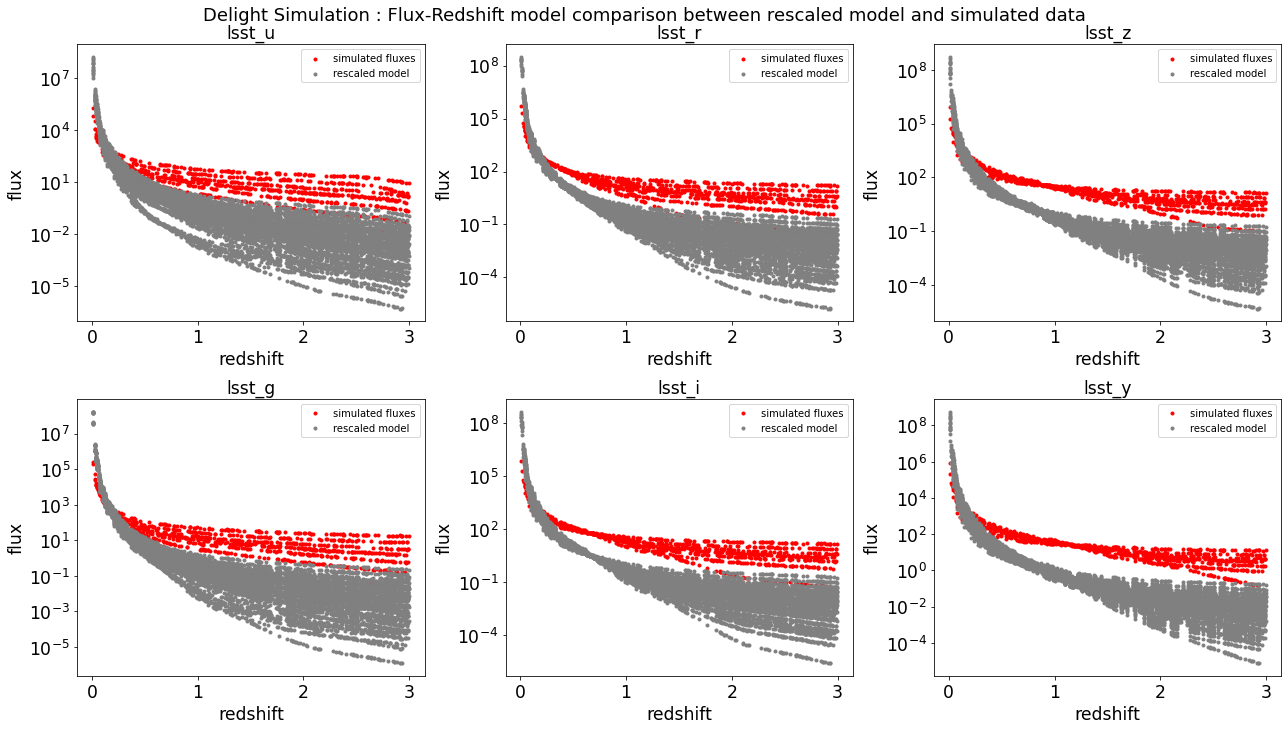

In [30]:
ncol=3
nrow=2
fig, axes = plt.subplots(nrow, ncol,figsize=(18,10)) 


for ifilt in np.arange(6):
    ix=ifilt//2
    iy=ifilt-ix*2
        
    
    axes[iy,ix].scatter(redshiftssim[:, 0],allFluxessim[:, ifilt],marker=".",color="r",label="simulated fluxes" )
    
    for t, sed_name in enumerate(sed_names): 
        if t==0:
            axes[iy,ix].scatter(redshiftssim[:, 0],fmod_atZsim[:, t,ifilt],marker='.',color='grey',label="rescaled model")
        else:
            axes[iy,ix].scatter(redshiftssim[:, 0],fmod_atZsim[:, t,ifilt],marker='.',color='grey')
    
    #axes[iy,ix].legend(loc="upper right")
    
    axes[iy,ix].set_yscale("log")
    axes[iy,ix].set_title(bandNames[ifilt])
    axes[iy,ix].set_xlabel("redshift")
    axes[iy,ix].set_ylabel("flux")
    axes[iy,ix].legend()
    
plt.tight_layout() 
plt.suptitle("Delight Simulation : Flux-Redshift model comparison between rescaled model and simulated data",fontsize=18,y=1.01)

    
            

## Read the DESC-DC3 Flux Redshift

In [31]:
numObjectsTraining = np.sum(1 for line in open(paramsdata['training_catFile']))

<ipython-input-31-b1c5549ea604>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(paramsdata['training_catFile']))


In [32]:
numMetrics = 7 + len(paramsdata['confidenceLevels'])

In [33]:
allFluxesdata = np.zeros((numObjectsTraining, numBands))
allFluxesVardata = np.zeros((numObjectsTraining, numBands))

redshiftsdata = np.zeros((numObjectsTraining, 1))
fmod_atZdata = np.zeros((numObjectsTraining, nt, numBands))

elldata= np.zeros(numObjectsTraining)

In [34]:
# Now loop over training set to compute likelihood function
loc = - 1
trainingDataIter = getDataFromFile(paramsdata, 0, numObjectsTraining,prefix="training_", getXY=False)

In [35]:
# loop on traning

for z, ell, bands, fluxes, fluxesVar, bCV, fCV, fvCV in trainingDataIter:
   
    loc += 1
    
    elldata[loc] =ell

   
    allFluxesdata[loc, :] = fluxes
    allFluxesVardata[loc, :] = fluxesVar
    redshiftsdata[loc, 0] = z
    
    # loop on SED
    for t, sed_name in enumerate(sed_names):
        for ib, b in enumerate(bands):
            fmod_atZdata[loc, t, ib] = ell * np.interp(z, redshiftGrid,f_mod[:, t, b])

### Normalisation factor distribution

Text(0.5, 1.0, 'Normalisation factor $\\ell$ for luminosity in desc data')

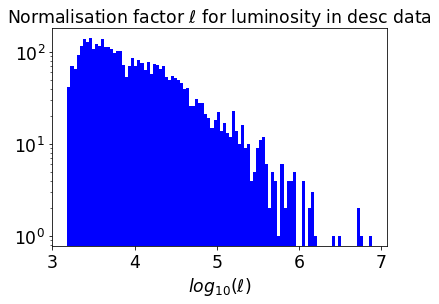

In [36]:
plt.hist(np.log10(elldata),bins=100,facecolor="b");
plt.yscale("log")
plt.xlabel("$log_{10}(\ell$)")
plt.title("Normalisation factor $\ell$ for luminosity in desc data")

In [37]:
elldata_mean=elldata.mean()

In [38]:
elldata_mean

40522.352801251494

Text(0.5, 1.01, 'Delight with DC2 : Flux-Redshift model comparison between model and simulated data')

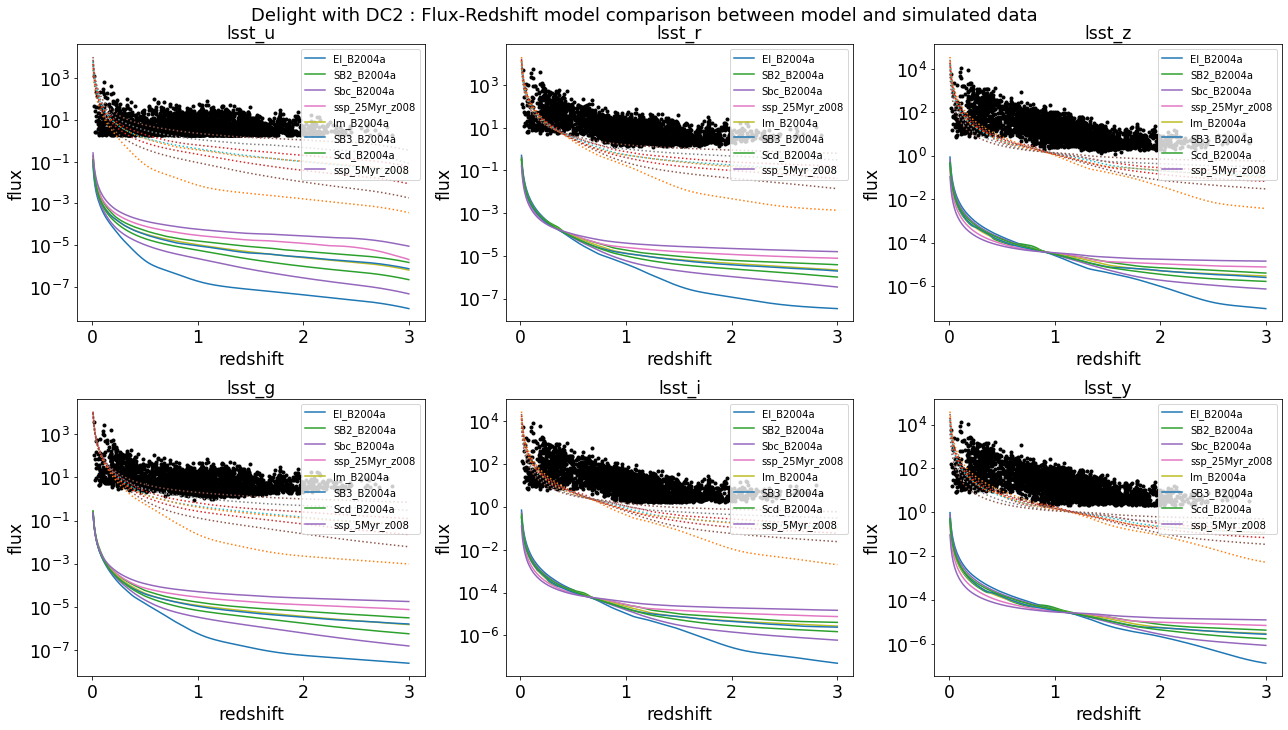

In [39]:
ncol=3
nrow=2
fig, axes = plt.subplots(nrow, ncol,figsize=(18,10)) 

for ised in np.arange(NSED):
    filename=files_sed_cww[ised]
    sedname=filename.split("_fluxredshiftmod")[0]
    fullfilename=os.path.join(topseddir,filename)
    flux=np.loadtxt(fullfilename)
    for ifilt in np.arange(6):
        ix=ifilt//2
        iy=ifilt-ix*2
        
        axes[iy,ix].plot(redshiftGrid,flux[:,ifilt],label=sedname)
        axes[iy,ix].plot(redshiftGrid,elldata_mean *flux[:,ifilt],":")
        axes[iy,ix].legend(loc="upper right")
        if ised==0:
            axes[iy,ix].set_yscale("log")
            axes[iy,ix].set_title(bandNames[ifilt])
            axes[iy,ix].set_xlabel("redshift")
            axes[iy,ix].set_ylabel("flux")
            axes[iy,ix].scatter(redshiftsdata[:, 0],allFluxesdata[:, ifilt],marker=".",color="k" )
            
plt.tight_layout()    

plt.tight_layout() 
plt.suptitle("Delight with DC2 : Flux-Redshift model comparison between model and simulated data",fontsize=18,y=1.01)


### Check Normalisation

Text(0.5, 1.01, 'Delight with DC2 : Flux-Redshift model comparison between rescaled model and DC2 data')

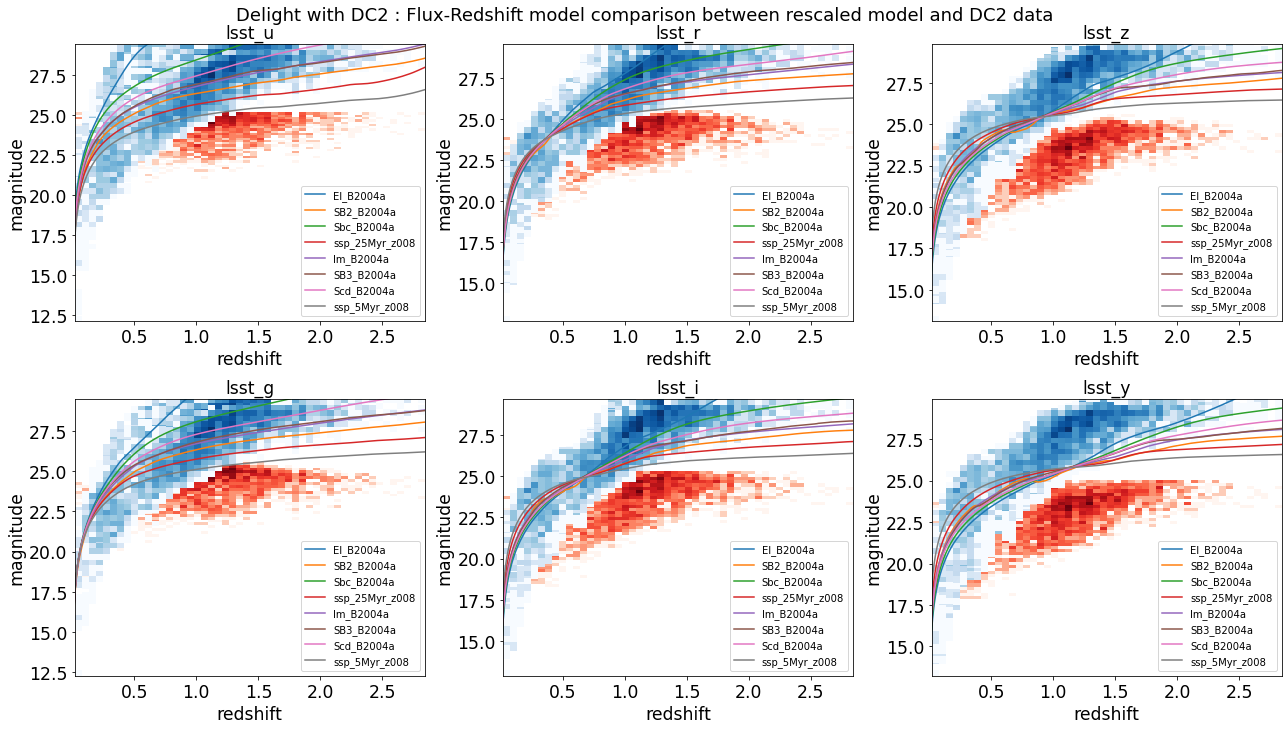

In [40]:
ncol=3
nrow=2
fig, axes = plt.subplots(nrow, ncol,figsize=(18,10)) 


for ifilt in np.arange(6):
    ix=ifilt//2
    iy=ifilt-ix*2
        
    
    axes[iy,ix].hist2d(redshiftsdata[:, 0],-2.5*np.log10(allFluxesdata[:, ifilt]*flux_multiplicative_factor),50,norm=LogNorm(),cmap="Reds",label="DC2 fluxes")
    
    for t, sed_name in enumerate(sed_names): 
        if t==0:
            axes[iy,ix].hist2d(redshiftsdata[:, 0],-2.5*np.log10(fmod_atZdata[:, t,ifilt]*flux_multiplicative_factor),50,cmap='Blues',norm=LogNorm(),label="rescaled model")
        else:
            axes[iy,ix].hist2d(redshiftsdata[:, 0],-2.5*np.log10(fmod_atZdata[:, t,ifilt]*flux_multiplicative_factor),50,cmap='Blues',norm=LogNorm())
                 
        filename=files_sed_cww[t]
        sedname=filename.split("_fluxredshiftmod")[0]
        fullfilename=os.path.join(topseddir,filename)
        flux=np.loadtxt(fullfilename)  
        
        axes[iy,ix].plot(redshiftGrid,-2.5*np.log10(flux[:,ifilt]*elldata_mean*flux_multiplicative_factor),"-",label=sedname)
    
    
    axes[iy,ix].legend(loc="lower right")
    
    #axes[iy,ix].set_yscale("log")
    axes[iy,ix].set_title(bandNames[ifilt])
    axes[iy,ix].set_xlabel("redshift")
    axes[iy,ix].set_ylabel("magnitude")
   
       
plt.tight_layout() 
plt.suptitle("Delight with DC2 : Flux-Redshift model comparison between rescaled model and DC2 data",fontsize=18,y=1.01)